# Evaluating Higher-order Fluid Simulations on the Taylor-Green Vortex

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/docs/prerendered/Taylor_Green_Comparison.ipynb)

This notebook compares the accuracy of various numerical schemes on the [Taylor-Green Vortex](https://en.wikipedia.org/wiki/Taylor_Green_vortex),
from semi-Lagrangian advection up to 6th order compact schemes.

**Warning:** Higher-order solvers are experimental in version 2.3. Only periodic boundary conditions are supported and the 6th-order implicit schemes does not yet support automatic matrix generation.

If [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow) 2.3 or newer is not already installed, uncomment the first line in the cell below.

In [1]:
# !pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@2.3-develop
import time
from functools import partial
from tqdm.notebook import trange
from phi.jax.flow import *

math.set_global_precision(64)  # double precision for all following operations

## Closed-Form Solution

The Taylor–Green vortex is an unsteady incompressible flow of a decaying vortex, and has an analytic solution, given below.

In [2]:
def taylor_green_velocity(x, t, viscosity=0.1):
    sin_x, sin_y = math.sin(x).vector
    cos_x, cos_y = math.cos(x).vector
    return vec(x=cos_x*sin_y, y=-sin_x*cos_y) * math.exp(-2 * viscosity * t)

def taylor_green_pressure(x, t, viscosity=0.1):
  return -1 / 4 * (math.sum(math.cos(2 * x), 'vector')) * math.exp(-4 * viscosity * t)

The speed of the vortex decay scales with the viscosity value. We will use a relatively low viscosity of 0.1, corresponding to a Reynolds number of 1/vis = 10.

Let's create a square domain of size 2π with a grid resolution of 25.
We sample the velocity on a [staggered grid](https://tum-pbs.github.io/PhiFlow/Staggered_Grids.html) and the pressure at the cell centers.

In [3]:
DOMAIN = dict(x=25, y=25, extrapolation=extrapolation.PERIODIC, bounds=Box(x=2*PI, y=2*PI))
TIME = math.linspace(0, 10., batch(time=200))
analytic_v = StaggeredGrid(partial(taylor_green_velocity, t=TIME), **DOMAIN)
analytic_p = CenteredGrid(partial(taylor_green_pressure, t=TIME), **DOMAIN)
plot({"Velocity": analytic_v, "Pressure": analytic_p}, animate='time')

<Figure size 432x288 with 0 Axes>

## Higher-order Simulation

Implementing a higher-order fluid solver requires higher-order spatial and temporal schemes.
We use Runge-Kutta 4 for time integration, employing the built-in `fluid.incompressible_rk4` function which takes care of the incompressibility part and lets us pass the rest of the PDE as a function.
In our case, this PDE function, `momentum_equation`, consists of an advection and diffusion term.
We parameterize the step function with the spatial order, so we can test multiple numerical schemes later, in particular the 6th order implicit scheme as well as a 4th and 2nd order explicit scheme.
For the pressure solve, 4th-order schemes are sufficient because the vortex is mainly diffusion-driven.

For the linear solves, we use the conjugate gradient method `'CG'` since the periodic boundaries result in symmetric linear equation systems for which CG is fastest. Similar to activating double precision mode, we set the Error tolerance low to demonstrate the full capabilities of the solver.

In [4]:
def momentum_equation(v, order: int, implicit: Solve, viscosity=0.1):
    advection = advect.finite_difference(v, v, order=order, implicit=implicit)
    diffusion = diffuse.finite_difference(v, viscosity, order=order, implicit=implicit)
    return advection + diffusion

@jit_compile(auxiliary_args='order,implicit,pressure_order', forget_traces=True)
def rk4_step(v, p, dt, order=6, implicit=None, pressure_order=4):
  return fluid.incompressible_rk4(momentum_equation, v, p, dt, order=order, implicit=implicit, pressure_order=pressure_order, pressure_solve=Solve('CG', 1e-12, 1e-12))

Now we can simulate and visualize the time evolution in high-order accuracy.

In [5]:
v_trj, p_trj = iterate(rk4_step, batch(time=200), analytic_v.time[0], analytic_p.time[0], dt=0.1, implicit=Solve('CG', 1e-12, 1e-12), range=trange)
vis.plot({"Velocity": v_trj, "Pressure": p_trj}, animate='time')

  0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

## Benchmark and Comparison
To compare the higher-order approach to different lower-order methods, we define two additional finite-difference schemes with lower orders and a semi-Lagrangian scheme that uses operator splitting instead of Runge-Kutta 4.

In [6]:
@jit_compile(forget_traces=True)
def semi_lagrangian_step(velocity, pressure, dt, viscosity=0.1):
  velocity = diffuse.explicit(velocity, viscosity, dt)
  velocity = advect.semi_lagrangian(velocity, velocity, dt)
  return fluid.make_incompressible(velocity, (), Solve('CG', 1e-12, 1e-12, x0=pressure))

methods = math.layout({
  '6th order implicit': partial(rk4_step, order=6, implicit=Solve('CG', 1e-12, 1e-12), pressure_order=4),
  '4th order': partial(rk4_step, order=4, pressure_order=4),
  '2nd order': partial(rk4_step, order=2, pressure_order=2),
  'Semi-Lagrangian': semi_lagrangian_step,
}, batch('method'))
expected_order = wrap([6, 4, 2, 1], methods.shape)

We will use a small step size of Δt = 0.001 to factor out the time advancement and put emphasis on the spatial discretization.
We target a simulation time of 0.5 seconds resulting in 500 frames.

We define the function `eval_error` to compute the error for a given method and `resolution` at every time step.
We run it on the four methods defined above with five resolutions each.
Note that this can take 15-20 min to run.

In [7]:
def eval_error(resolution, step_function, dt=0.001, time_sec=.5):
  domain = dict(x=resolution, y=resolution, extrapolation=extrapolation.PERIODIC, bounds=Box(x=2*PI, y=2*PI))
  times = math.linspace(0, time_sec, batch(time=math.round(time_sec/dt)+1))
  analytic_v = StaggeredGrid(partial(taylor_green_velocity, t=times), **domain)
  analytic_p = CenteredGrid(partial(taylor_green_pressure, t=times), **domain)
  v, p = analytic_v.time[0], analytic_p.time[0]
  (sim_v, _), exec_times = iterate(step_function, times.shape - 1, v, p, dt=dt, measure=time.perf_counter)
  rmse = math.sqrt(math.mean((analytic_v - sim_v).values**2))
  relative_err = rmse / math.mean(abs(analytic_v.values))
  return relative_err, exec_times.time[1:].mean  # ignore jit compilation time

resolutions = wrap([8, 16, 32, 64, 128], batch(resolution='8, 16, 32, 64, 128'))
errors, exec_times = math.map(eval_error, resolutions, methods, range=trange)

  0%|          | 0/20 [00:00<?, ?it/s]

Let's take a look at how the errors develop over time.
In the following figure, each method is drawn in a subplot. The differently-colored trajectories represent error curves of differing resolutions.

<Figure size 864x360 with 4 Axes>

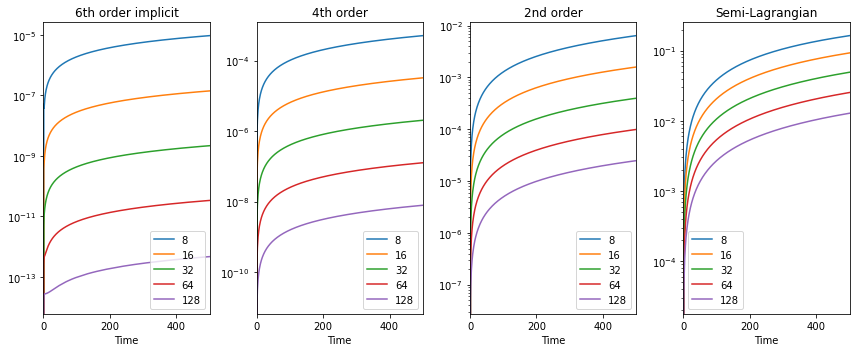

In [8]:
plot(errors.resolution.as_channel().time.as_spatial(), log_dims='_')

Next we visualise the final error with respect to the resolution in a log-log plot. This allows us to easily see the order of accuracy.
For each simulation scheme, we draw a corresponding theoretical curve (orders 6, 4, 2, 1) in the same color slightly below.

<Figure size 432x432 with 1 Axes>

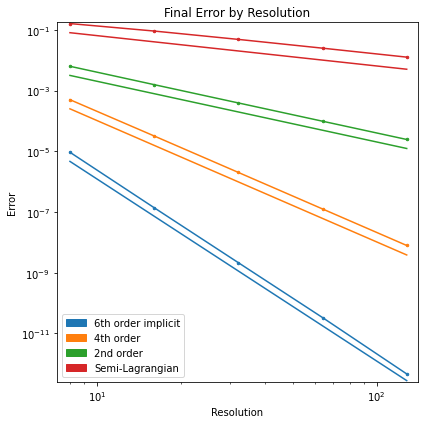

In [9]:
expected_lines = vec(resolution=resolutions.resolution[(0, -1)], error=errors.time[-1].resolution[0]*.5*stack([1, (resolutions.min/resolutions.max)**expected_order], batch('resolution')))
plot(vec(resolution=resolutions, error=errors.time[-1]).resolution.as_spatial().method.as_channel(),
     expected_lines.resolution.as_spatial().method.as_channel(),
     overlay='args', log_dims='resolution,error', title="Final Error by Resolution", size=(6, 6))

Next, we plot the execution times per resolution and method.

<Figure size 864x360 with 1 Axes>

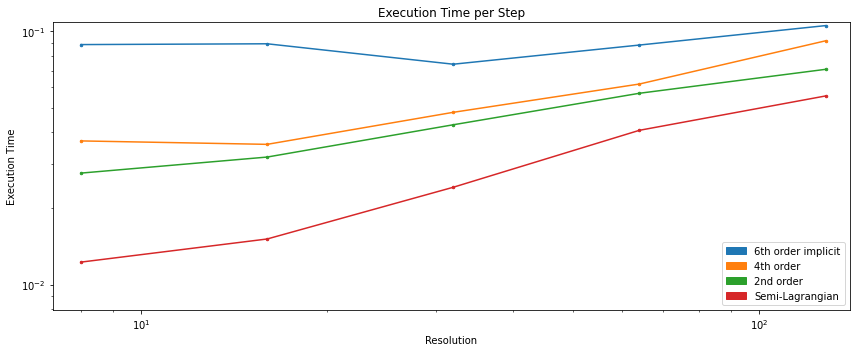

In [10]:
plot(vec(resolution=resolutions, execution_time=exec_times).resolution.as_spatial().method.as_channel(),
     log_dims='execution_time,resolution', title="Execution Time per Step")

Combining the previous two figures into one, we can plot the error against the execution time.

<Figure size 864x360 with 1 Axes>

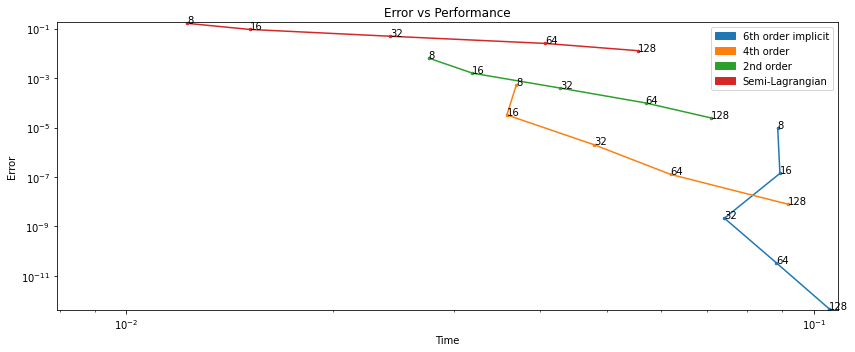

In [11]:
plot(vec(time=exec_times, error=errors.time[-1]).resolution.as_spatial().method.as_channel(),
     log_dims='error,time', title="Error vs Performance")

As expected, higher orders are more expensive but yield better accuracy.
When computation time is limited, the highest order of accuracy is not always preferable, especially since the computational cost of the implicit 6th-order scheme is approximately constant below a resolution of 32.